# Part 1 of 4 - Discrete Fourier Transformation (DFT)

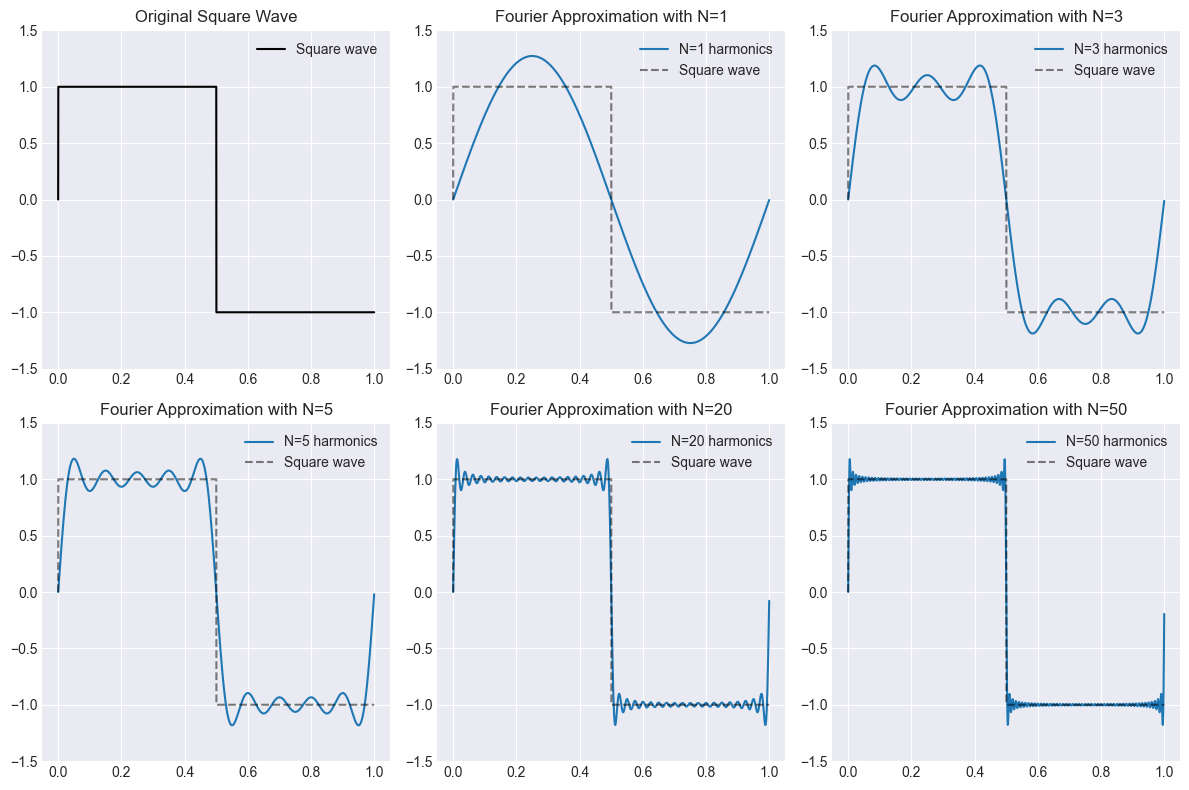

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Set parameters for the signal
N = 2048  # Number of sample points
T = 1.0   # Duration of the signal in seconds
f0 = 1    # Fundamental frequency of the square wave in Hz

# List of harmonic numbers used to construct the square wave
harmonics = [1, 3, 5, 20, 50]

# Define the square wave function
def square_wave(t):
    return np.sign(np.sin(2.0 * np.pi * f0 * t))

# Fourier series approximation of the square wave
def square_wave_fourier(t, f0, N):
    result = np.zeros_like(t)
    for k in range(N):
        # The Fourier series of a square wave contains only odd harmonics.
        n = 2 * k + 1
        # Add harmonics to reconstruct the square wave.
        result += np.sin(2 * np.pi * n * f0 * t) / n
    return (4 / np.pi) * result

# Create the time vector
# np.linspace generates evenly spaced numbers over a specified interval.
# We use endpoint=False because the interval is periodic.
t = np.linspace(0.0, T, N, endpoint=False)

# Generate the original square wave
square = square_wave(t)

plt.figure(figsize=(12, 8))

# Plot the original square wave
plt.subplot(2, 3, 1)
plt.plot(t, square, 'k', label="Square wave")
plt.title("Original Square Wave")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Plot Fourier reconstructions under different number of harmonics
for i, Nh in enumerate(harmonics, start=2):
    plt.subplot(2, 3, i)
    y = square_wave_fourier(t, f0, Nh)
    plt.plot(t, y, label=f"N={Nh} harmonics")
    plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
    plt.title(f"Fourier Approximation with N={Nh}")
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


--- DFT/FFT Performance Comparison ---
Naïve DFT Execution Time: 3.715894 seconds
NumPy FFT Execution Time: 0.001752 seconds
FFT is approximately 2120.78 times faster.

Our DFT implementation is close to NumPy's FFT: True


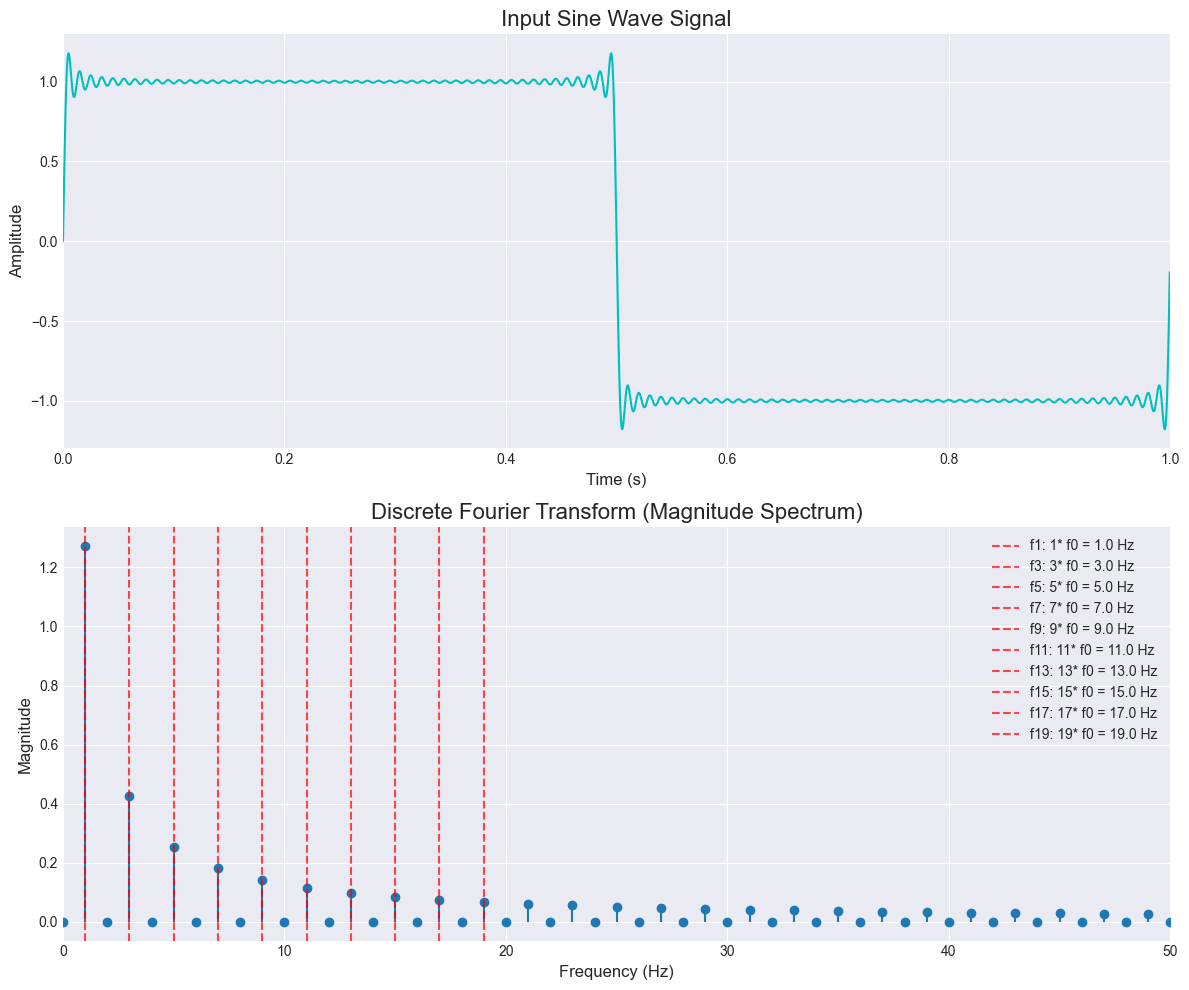

In [19]:
# 2. Apply the DFT and time the execution
def naive_dft(x):
    """
    Compute the Discrete Fourier Transform (DFT) of a 1D signal.
    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).

    Args:
        x (np.ndarray): The input signal, a 1D NumPy array.

    Returns:
        np.ndarray: The complex-valued DFT of the input signal.
    """
    N = len(x)
    # Create an empty array of complex numbers to store the DFT results
    X = np.zeros(N, dtype=np.complex128)

    # Iterate through each frequency bin (k)
    for k in range(N):
        # For each frequency bin, sum the contributions from all input samples (n)
        for n in range(N):
            # The core DFT formula: x[n] * e^(-2j * pi * k * n / N)
            angle = -2j * np.pi * k * n / N
            X[k] += x[n] * np.exp(angle)

    return X


# Construct a square wave using 50 harmonics
signal = square_wave_fourier(t, f0, 50)

# Time the naïve DFT implementation
start_time_naive = time.time()
dft_result = naive_dft(signal)
end_time_naive = time.time()
naive_duration = end_time_naive - start_time_naive

# Time NumPy's FFT implementation
start_time_fft = time.time()
fft_result = np.fft.fft(signal)
end_time_fft = time.time()
fft_duration = end_time_fft - start_time_fft

# 3. Print Timings and Verification
print("--- DFT/FFT Performance Comparison ---")
print(f"Naïve DFT Execution Time: {naive_duration:.6f} seconds")
print(f"NumPy FFT Execution Time: {fft_duration:.6f} seconds")

# It's possible for the FFT to be so fast that the duration is 0.0, so we handle that case.
if fft_duration > 0:
    print(f"FFT is approximately {naive_duration / fft_duration:.2f} times faster.")
else:
    print("FFT was too fast to measure a significant duration difference.")

# Check if our implementation is close to NumPy's result
# np.allclose is used for comparing floating-point arrays.
print(f"\nOur DFT implementation is close to NumPy's FFT: {np.allclose(dft_result, fft_result)}")

# 4. Prepare for Plotting
# Generate the frequency axis for the plot.
# np.fft.fftfreq returns the DFT sample frequencies.
# We only need the first half of the frequencies (the positive ones) due to symmetry.
xf = np.fft.fftfreq(N, d=T/N)[:N//2]

# We normalize the magnitude by N and multiply by 2 to get the correct amplitude.
magnitude = 2.0/N * np.abs(dft_result[0:N//2])

# 5. Visualize the Results
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the original time-domain signal
ax1.plot(t, signal, color='c')
ax1.set_title('Input Sine Wave Signal', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_xlim(0, 1.0)  # Show a few cycles of the sine wave
ax1.grid(True)

# Plot the frequency-domain signal (magnitude of the DFT)
ax2.stem(xf, magnitude, basefmt=" ")
ax2.set_title('Discrete Fourier Transform (Magnitude Spectrum)', fontsize=16)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.set_xlim(0, 50)  # Focus on lower frequencies
ax2.grid(True)

# Add vertical lines for the first ten frequencies
for i in range(20):
    if i < len(xf) and i % 2 == 1:  # Only plot odd harmonics
        ax2.axvline(
            xf[i], color='r', linestyle='--', alpha=0.7,
            label=f'f{i}: {i}* f0 = {xf[i]:.1f} Hz'
        )

# Only show labels for first 3 frequencies to avoid cluttering
ax2.legend()

plt.tight_layout()
plt.show()


# Part 2 of 4 - Eigenfaces

In [20]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

# Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

# project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1002)>